**Imports**

In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
from numpy import pi
import numpy as np
from thesis.main import main, rollout
from thesis.util import animate
from IPython.display import display, HTML
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from IPython.display import Image

The **Mathematical Pendulum** environment is used in the following examples. At first, we have to register it.

In [2]:
from gym.envs.registration import register
# Register environment
register(
    id='MathPendulum-v0',
    max_episode_steps=100,
    entry_point='sb3_contrib.common.envs.pendulum.math_pendulum_env:MathPendulumEnv'
)

In order to define the safe space, one has to initialise a **SafeRegion**. Pass the vertex- or half-space to define the polytope that represents it).

The safe region for the pendulum environment is a precomputed region of attraction. It is defined via LQR constraints. Consequently, we also use the LQR controller as a fail-safe backup. The safe region has been manually passed to the environment a posteriori, since the environment only needs it for visualisation purposes: Once the pendulum violates the safety restriction, we turn its color orange. We will need it later, though!

In [5]:
from sb3_contrib.common.safety.safe_region import SafeRegion
# Precomputed safe region
max_thdot = 5.890486225480862
vertices = np.array([
        [-pi, max_thdot],  
        [-0.785398163397448, max_thdot],  
        [pi, -max_thdot],
        [0.785398163397448, -max_thdot]
])
# Pass as vertex or half-space representation.
safe_region = SafeRegion(vertices=vertices)

The utility method *rollout* can be used to sample from the environment. Without further configuration, random and continuous actions will be taken. One should see that we quickly breach the safe region (bob turns orange).<br> **Note**: If you rollout a, you might have to force-quit the window (or leave it open until the end).

In [12]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_cont.gif', writer='imagemagick', fps=30)

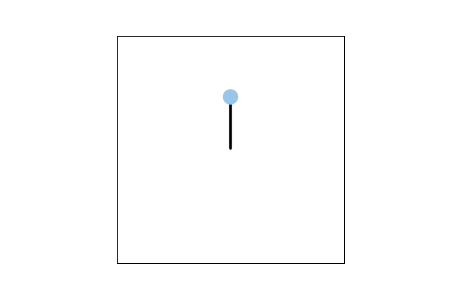

In [13]:
with open('gifs/sample_cont.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

Our RL policy should work with discrete actions. Nevertheless, some safety approaches or fail-safe controllers might work with continuous actions. The wrapper **action_discretizer** wraps an environment using a continuous action space and transforms it into a discrete using one.

In [3]:
from sb3_contrib.common.wrappers.action_discretizer import ActionDiscretizer
from gym.spaces import Discrete

# Initialise environment
env = gym.make('MathPendulum-v0')
# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15), #Pass the new discrete action space
    transform_fn=lambda a:2*(a-7) #Pass an unbounded transformation function (discrete -> continuous action)
)
# ... 

For further safety approaches down below, we need a fail-safe controller. Here we utilise a LQR-controller.<br> The MathPendulumEnv already implements it as part of the **safe_action** method (can be triggered manually for debugging purposes).

In [5]:
# Initialise environment
env = gym.make('MathPendulum-v0')
# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, env_safe_action=True, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, env_safe_action=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_lqr.gif', writer='imagemagick', fps=30)

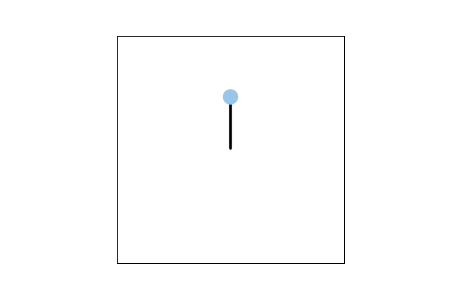

In [15]:
with open('gifs/sample_lqr.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**Safety Wrappers**

Every safety wrapper expects to be given a **SafeRegion** (see above). Further parameters depend on the specific wrapper.

**SafetyShield**

- **is_safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion, float], bool]]<br>
Given the env, the safe region and the action, this method returns a bool whether the action would be safe to take.<br>

- **safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion], float]]<br>
Given the env and the safe region, this method returns a fail-safe action to be taken if the policy's action is unsafe. <br>

- **punishment_fn**: punishment_fn: Optional[Union[str, Callable[[gym.Env, SafeRegion, float, float], float]]] = None<br>
Given the env, the safe region, the policy's action and the shield's action, this method returns a reward which is added to the total reward, i.e. most likely you want to return a negative reward. Note: It is only called whenever the shield is active.

These functions can be passed as unbounded functions or, if already implemented in the environment, as according str.

In [5]:
from sb3_contrib.common.wrappers import SafetyShield

def is_safe_action(env: gym.Env, safe_region: SafeRegion, action: float):
    # Specific to environment
    theta, thdot = env.state
    state = env.dynamics(theta, thdot, action) 
    return state in safe_region

def punishment_fn(env: gym.Env, safe_region: SafeRegion, action: float, action_shield: float) -> float:
                return -abs(action - action_shield)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyShield
env = SafetyShield(
                env=env,
                safe_region=safe_region,
                is_safe_action_fn=is_safe_action,
                safe_action_fn="safe_action", #Example: already implemented (LQR controller)
                punishment_fn=punishment_fn)

# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15),
    transform_fn=lambda a:2*(a-7)
)

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_shield.gif', writer='imagemagick', fps=30)

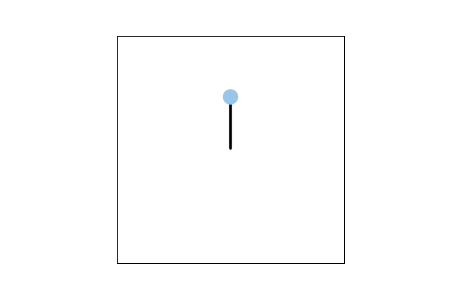

In [6]:
with open('gifs/sample_shield.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**SafetyCBF**

- **is_safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion, float], bool]]<br>
Given the env, the safe region and the action, this method returns a bool whether the action would be safe to take.<br>

- **safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion], float]]<br>
Given the env and the safe region, this method returns a fail-safe action to be taken if the policy's action is unsafe. <br>

- **punishment_fn**: punishment_fn: Optional[Union[str, Callable[[gym.Env, SafeRegion, float, float], float]]] = None<br>
Given the env, the safe region, the policy's action and the shield's action, this method returns a reward which is added to the total reward, i.e. most likely you want to return a negative reward. Note: It is only called whenever the shield is active.

These functions can be passed as unbounded functions or, if already implemented in the environment, as according str.

In [6]:
from sb3_contrib.common.wrappers import SafetyCBF

def punishment_fn(env: gym.Env, safe_region: SafeRegion, action: float, action_bar: float) -> float:
                return -abs(action - action_bar)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyCBF
env = SafetyCBF(
                env=env,
                safe_region=safe_region,
                f = None,
                g = None,
                gamma = .5,
                punishment_fn=punishment_fn)

# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15),
    transform_fn=lambda a:2*(a-7)
)

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_cbf.gif', writer='imagemagick', fps=30)

In [ ]:
with open('gifs/sample_cbf.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

**SafetyMask**

- **safe_mask_fn**: Union[str, Callable[[gym.Env, SafeRegion, float], np.ndarray]]<br>
Given the env, the safe region and the action, this method returns a binary mask (0 unsafe actions; 1 safe actions)<br>

- **safe_action_fn**: Union[str, Callable[[gym.Env, SafeRegion], float]]<br>
Given the env and the safe region, this method returns a fail-safe action to be taken if the policy's action is unsafe. <br>

These functions can be passed as unbounded functions or, if already implemented in the environment, as according str.

In [ ]:
from sb3_contrib.common.wrappers import SafetyMask

def safe_mask_fn(env: gym.Env, safe_region: SafeRegion, action:float) -> np.ndarray:
    theta, thdot = env.state
    mask = np.ones(15)
    for i in range(15):
        if env.dynamics(theta, thdot, 2 * (i - 7)) not in safe_region:
            mask[i] = False
    return mask

def punishment_fn(env: gym.Env, safe_region: SafeRegion, action: float, action_bar: float) -> float:
        return -abs(action - action_bar)

# Initialise environment
env = gym.make('MathPendulum-v0')

# Wrap with SafetyMask
env = SafetyMask(
        env=env,
        safe_region=safe_region,
        safe_mask_fn=safe_mask_fn,
        safe_action_fn="safe_action", #Example: already implemented (LQR controller)
        punishment_fn=punishment_fn)

# Discretize actions
env = ActionDiscretizer(
    env=env,
    disc_action_space=Discrete(15),
    transform_fn=lambda a:2*(a-7)
)

# Wrap with Monitor (suppresses warnings)
env = Monitor(env)
# Wrap with DummyVecEnv
env = DummyVecEnv([lambda: env])

# Rollout
#rollout(env, render=True, rgb_array=False, sleep=.1)

# Rollout and save as gif
#frames = rollout(env, render=True, rgb_array=True, sleep=0)
#anim = animate(frames, dpi=75)
#anim.save('gifs/sample_mask.gif', writer='imagemagick', fps=30)

In [ ]:
with open('gifs/sample_mask.gif','rb') as f:
    display(Image(data=f.read(), format='png'))